<a href="https://colab.research.google.com/github/az1zz/AI_Projects/blob/main/ImageSearch_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Search with EfficientNetV2 & PCA**
In this notebook, we will implement **Image Search** using **EfficientNetV2-Small** for feature extraction and **PCA** for dimensionality reduction.

**Steps:**
**Extract Features** using a **Pretrained EfficientNetV2-S Model**  
**Reduce Dimensions** with **PCA**  
**Find Similar Images** using **Cosine Similarity**  
**Visualize Query & Retrieved Images**  

---

##**1 - Load Dataset**
We use **Caltech 101 dataset**, which contains **101 object categories** with high-quality images.


In [ ]:
# Download the dataset
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

############################################################################################# 100.0%
Archive:  101_ObjectCategories.zip
   creating: caltech-101/
  inflating: __MACOSX/._caltech-101  
  inflating: caltech-101/101_ObjectCategories.tar.gz  
  inflating: __MACOSX/caltech-101/._101_ObjectCategories.tar.gz  
  inflating: caltech-101/show_annotation.m  
  inflating: __MACOSX/caltech-101/._show_annotation.m  
  inflating: caltech-101/Annotations.tar  
  inflating: __MACOSX/caltech-101/._Annotations.tar  
101_ObjectCategories  101_ObjectCategories.zip	caltech-101  __MACOSX  sample_data


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random
import os

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset
dataset_path = "101_ObjectCategories"
dataset = ImageFolder(root=dataset_path, transform=transform)

In [ ]:
# Select a subset for faster processing
n_images = 1000  # num images to keep in the dataset.
random_indices = random.sample(range(len(dataset)), n_images)
print(len(np.unique(random_indices)))
images_subset = Subset(dataset, random_indices)

# Use a Dataloader
batch_size = 64
image_loader = DataLoader(images_subset, batch_size, shuffle=False, num_workers=2)

1000


##**2 - Feature Extraction using EfficientNetV2-S**
We use a **pretrained EfficientNetV2-S model** and modify it to **extract features before classification**.


In [ ]:
import torch
import torchvision.models as models
from torch import nn
from tqdm import tqdm

# Load pretrained EfficientNetV2-S model
device = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
efficientnet.eval().to(device)

# Modify EfficientNetV2-S to extract features before classification
def extract_features(image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        features = efficientnet.features(image_tensor)  # Extract features, Shape = (64, 1280, 7, 7)
        features = torch.flatten(features, start_dim=1)  # Flatten before passing to classifier, Shape = (64, 62720)
        # features = efficientnet.classifier[0](features)  # Pass through first layer of classifier
    return features

# Extract features for all images
all_features = []
image_tensors = []

for images, _ in tqdm(image_loader):
    image_tensors.append(images)
    features = extract_features(images)
    all_features.append(features.cpu())

# Convert to numpy
all_features = torch.cat(all_features).numpy()
image_tensors = torch.cat(image_tensors)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 213MB/s]
100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


##**3 - Apply PCA for Dimensionality Reduction**
Since **EfficientNetV2-S outputs high-dimensional features**, we apply **PCA** to reduce dimensions and speed up search.


In [ ]:
print(f"shape of features: {all_features.shape}")
print(f" number of batches: {len(image_loader)}")
print(f"shape of images loader: {(next(iter(image_loader)))[0].shape}")

shape of features: (1000, 62720)
 number of batches: 16
shape of images loader: torch.Size([64, 3, 224, 224])


In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA
n_pca_components = .95  # Number of principal components to keep
pca = PCA(n_components=n_pca_components)
pca_features = pca.fit_transform(all_features)

In [ ]:
print(f"we have {np.cumsum(pca.explained_variance_ratio_)[-1]:.4f} variation retained with only {pca.n_components_} features left.")

we have 0.9502 variation retained with only 618 features left.


##**4 - Image Retrieval using Cosine Similarity**
To retrieve similar images:

Compute **cosine similarity** between query image and dataset.  
Retrieve **top 5 most similar images**.  



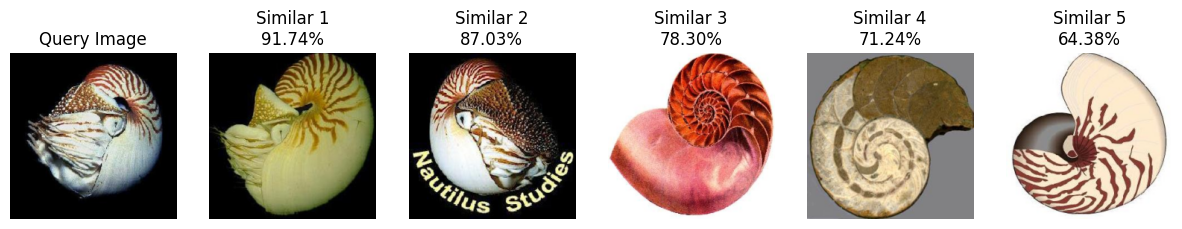

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Select a random query image
random_idx = random.randint(0, len(pca_features) - 1)
query_image = image_tensors[random_idx]
query_features = pca_features[random_idx]

# Compute cosine similarity
similarities = cosine_similarity(pca_features, query_features.reshape(1, -1)).reshape(-1)

# Get top 5 similar images
top_indices = similarities.argsort()[-6:-1][::-1]  # Ignore query itself

# Display query & retrieved images with similarity scores
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

# Query image
axes[0].imshow(query_image.permute(1, 2, 0).numpy())
axes[0].set_title("Query Image")
axes[0].axis("off")

# Retrieved similar images with similarity scores
for i, idx in enumerate(top_indices):
    image = image_tensors[idx]
    similarity_score = similarities[idx]  # Get similarity score
    axes[i + 1].imshow(image.permute(1, 2, 0).numpy())
    axes[i + 1].set_title(f"Similar {i+1}\n{100*similarity_score:.2f}%")  # Show similarity score
    axes[i + 1].axis("off")

plt.show()
